<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" height=300 width=300 />


# Final Project: League of Legends Match Predictor 


### Setup
Installing required libraries:


In [1]:
!pip install pandas
!pip install scikit-learn
!pip install torch
!pip install matplotlib

Exercise 1: Write a code to load the dataset, split it into training and testing sets, standardize the features, and convert the data into PyTorch tensors for use in training a PyTorch model. 

In [2]:
## Write your code here
import pandas as pd
data = pd.read_csv("league_of_legends_data_large.csv")
X = data.drop('win', axis=1)
y = data['win']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for training and test sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Step 2: Logistic Regression Model  

#### Task 2: Implement a logistic regression model using PyTorch.  

Defining the logistic regression model involves specifying the input dimensions, the forward pass using the sigmoid activation function, and initializing the model, loss function, and optimizer.  

#### Exercise 2:  

Define the logistic regression model using PyTorch, specifying the input dimensions and the forward pass. Initialize the model, loss function, and optimizer.  


In [3]:
## Write your code here
import torch.nn as nn
import torch.optim as optim

print(X_train.shape[1])#this gives input_units=8

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_units=8):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_units,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.linear(x)).squeeze(1)
        return x

model = LogisticRegressionModel(X_train.shape[1])
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

8


### Step 3: Model Training  

#### Task 3: Train the logistic regression model on the dataset.  

The training loop will run for a specified number of epochs. In each epoch, the model makes predictions, calculates the loss, performs backpropagation, and updates the model parameters.

#### Exercise 3:  

Write the code to train the logistic regression model on the dataset. Implement the training loop, making predictions, calculating the loss, performing backpropagation, and updating model parameters. Evaluate the model's accuracy on training and testing sets.  


In [4]:
# Write your code here
epochs = 1000
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        #print(outputs.shape, y_batch.shape)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    if (epoch+1) %100==0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        
#Accuracy
from sklearn.metrics import accuracy_score

ypred_train = model(X_train)
label_train = (ypred_train > 0.5).int()
train_accuracy = accuracy_score(y_train, label_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

ypred_test = model(X_test)
label_test = (ypred_test > 0.5).int()
test_accuracy = accuracy_score(y_test, label_test)
print(f"test: {test_accuracy:.4f}")


Epoch [100/1000], Train Loss: 0.6996, Test Loss: 0.6906
Epoch [200/1000], Train Loss: 0.6995, Test Loss: 0.6836
Epoch [300/1000], Train Loss: 0.6976, Test Loss: 0.6879
Epoch [400/1000], Train Loss: 0.6988, Test Loss: 0.6782
Epoch [500/1000], Train Loss: 0.6991, Test Loss: 0.6841
Epoch [600/1000], Train Loss: 0.6991, Test Loss: 0.6807
Epoch [700/1000], Train Loss: 0.6987, Test Loss: 0.6786
Epoch [800/1000], Train Loss: 0.6997, Test Loss: 0.6854
Epoch [900/1000], Train Loss: 0.7002, Test Loss: 0.6825
Epoch [1000/1000], Train Loss: 0.7001, Test Loss: 0.6749
Training Accuracy: 0.5225
test: 0.5500


### Step 4: Model Optimization and Evaluation  

#### Task 4: Implement optimization techniques and evaluate the model's performance.  

Optimization techniques such as L2 regularization (Ridge Regression) help in preventing overfitting. The model is retrained with these optimizations, and its performance is evaluated on both training and testing sets. 

**Weight Decay** :In the context of machine learning and specifically in optimization algorithms, weight_decay is a parameter used to apply L2 regularization to the model's parameters (weights). It helps prevent the model from overfitting by penalizing large weight values, thereby encouraging the model to find simpler solutions.To use L2 regularization, you need to modify the optimizer by setting the weight_decay parameter. The weight_decay parameter in the optimizer adds the L2 regularization term during training.
For example, when you initialize the optimizer with optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01), the weight_decay=0.01 term applies L2 regularization with a strength of 0.01.

#### Exercise 4:  

Implement optimization techniques like L2 regularization and retrain the model. Evaluate the performance of the optimized model on both training and testing sets.  


In [5]:
## Write your code here
import torch.nn as nn
import torch.optim as optim

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_units=8):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_units,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.linear(x)).squeeze(1)
        return x

model = LogisticRegressionModel(X_train.shape[1])
# Define the loss function and optimizer|
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

epochs = 1000
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        #print(outputs.shape, y_batch.shape)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    if (epoch+1) %100==0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        
#Accuracy
from sklearn.metrics import accuracy_score

ypred_train = model(X_train)
label_train = (ypred_train > 0.5).int()
train_accuracy = accuracy_score(y_train, label_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

ypred_test = model(X_test)
label_test = (ypred_test > 0.5).int()
test_accuracy = accuracy_score(y_test, label_test)
print(f"test: {test_accuracy:.4f}")

Epoch [100/1000], Train Loss: 0.6992, Test Loss: 0.6871
Epoch [200/1000], Train Loss: 0.6993, Test Loss: 0.6821
Epoch [300/1000], Train Loss: 0.6971, Test Loss: 0.6902
Epoch [400/1000], Train Loss: 0.6985, Test Loss: 0.6846
Epoch [500/1000], Train Loss: 0.6991, Test Loss: 0.6858
Epoch [600/1000], Train Loss: 0.6993, Test Loss: 0.6832
Epoch [700/1000], Train Loss: 0.6986, Test Loss: 0.6866
Epoch [800/1000], Train Loss: 0.6979, Test Loss: 0.6984
Epoch [900/1000], Train Loss: 0.6991, Test Loss: 0.6856
Epoch [1000/1000], Train Loss: 0.6999, Test Loss: 0.6836
Training Accuracy: 0.5437
test: 0.5650


### Step 5: Visualization and Interpretation  

Visualization tools like confusion matrices and ROC curves provide insights into the model's performance. The confusion matrix helps in understanding the classification accuracy, while the ROC curve illustrates the trade-off between sensitivity and specificity.

Confusion Matrix : A Confusion Matrix is a fundamental tool used in classification problems to evaluate the performance of a model. It provides a matrix showing the number of correct and incorrect predictions made by the model, categorized by the actual and predicted classes.
Where 
-  True Positive (TP): Correctly predicted positive class (class 1).
- True Negative (TN): Correctly predicted negative class (class 0).
- False Positive (FP): Incorrectly predicted as positive (class 1), but the actual class is negative (class 0). This is also called a Type I error.
- False Negative (FN): Incorrectly predicted as negative (class 0), but the actual class is positive (class 1). This is also called a Type II error. 

ROC Curve (Receiver Operating Characteristic Curve):
The ROC Curve is a graphical representation used to evaluate the performance of a binary classification model across all classification thresholds. It plots two metrics:
- True Positive Rate (TPR) or Recall (Sensitivity)-It is the proportion of actual positive instances (class 1) that were correctly classified as positive by the model.
- False Positive Rate (FPR)-It is the proportion of actual negative instances (class 0) that were incorrectly classified as positive by the model.
  
AUC: 
AUC stands for Area Under the Curve and is a performance metric used to evaluate the quality of a binary classification model. Specifically, it refers to the area under the ROC curve (Receiver Operating Characteristic curve), which plots the True Positive Rate (TPR) versus the False Positive Rate (FPR) for different threshold values.

Classification Report:
A Classification Report is a summary of various classification metrics, which are useful for evaluating the performance of a classifier on the given dataset.

#### Exercise 5:  

Write code to visualize the model's performance using confusion matrices and ROC curves. Generate classification reports to evaluate precision, recall, and F1-score. Retrain the model with L2 regularization and evaluate the performance.


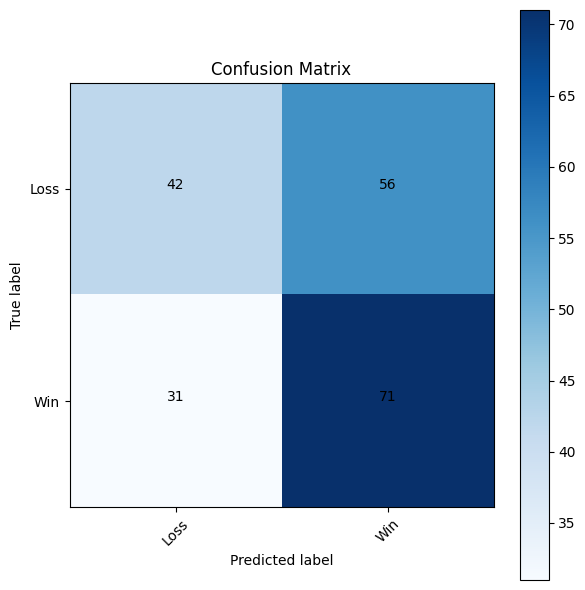

Classification Report:
               precision    recall  f1-score   support

        Loss       0.58      0.43      0.49        98
         Win       0.56      0.70      0.62       102

    accuracy                           0.56       200
   macro avg       0.57      0.56      0.56       200
weighted avg       0.57      0.56      0.56       200



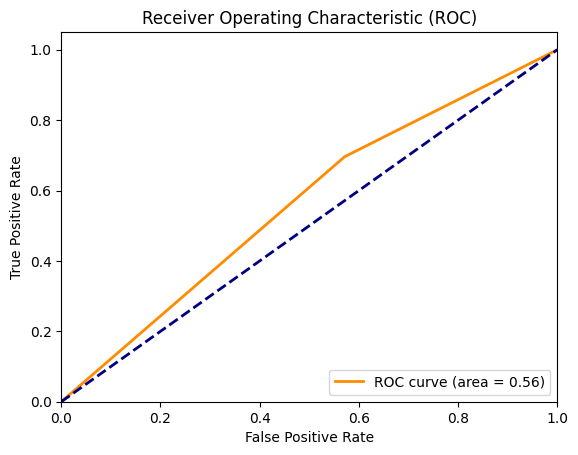

In [6]:
## Write your code here
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools


# Visualize the confusion matrix
ypred_test = model(X_test)
label_test = (ypred_test > 0.5).int()
cm = confusion_matrix(y_test, label_test)

# Visualize the confusion matrix
#Change the variable names as used in your code
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Loss', 'Win'], rotation=45)
plt.yticks(tick_marks, ['Loss', 'Win'])

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="black" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_test, label_test, target_names=['Loss', 'Win']))
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, label_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Step 6: Model Saving and Loading  

#### Task 6: Save and load the trained model.  

This task demonstrates the techniques to persist a trained model using `torch.save` and reload it using `torch.load`. Evaluating the loaded model ensures that it retains its performance, making it practical for deployment in real-world applications.  


#### Exercise 6:  

Write code to save the trained model and reload it. Ensure the loaded model performs consistently by evaluating it on the test dataset.  


In [7]:
# Save the model
torch.save(model.state_dict(), 'model_logistic_reg.pth')
# Load the model
model2=LogisticRegressionModel()
model2.load_state_dict(torch.load('model_logistic_reg.pth', weights_only=True))

# Evaluation phase on test set
model2.eval()
#ensure consistent performance
with torch.no_grad():
    original_preds = (model(X_test) > 0.5).int()
    loaded_preds = (model2(X_test) > 0.5).int()
assert torch.equal(original_preds, loaded_preds), "Mismatch in predictions!" #makes sure we get same predictions
original_accuracy = accuracy_score(y_test, original_preds)
loaded_accuracy = accuracy_score(y_test, loaded_preds)
print(f"Original Model Accuracy: {original_accuracy:.4f}")
print(f"Loaded Model Accuracy: {loaded_accuracy:.4f}")
# Verify accuracies match
assert original_accuracy == loaded_accuracy, "Mismatch in accuracy after loading!" #makes sure we get same accuracy

Original Model Accuracy: 0.5650
Loaded Model Accuracy: 0.5650


### Step 7: Hyperparameter Tuning  

#### Task 7: Perform hyperparameter tuning to find the best learning rate.  

By testing different learning rates, you will identify the optimal rate that provides the best test accuracy. This fine-tuning is crucial for enhancing model performance . 
1. Define Learning Rates:
   - Choose these learning rates to test ,[0.01, 0.05, 0.1]

2. Reinitialize the Model for Each Learning Rate:
  - For each learning rate, you’ll need to reinitialize the model and optimizer e.g.(`torch.optim.SGD(model.parameters(), lr=lr)`).
   - Each new learning rate requires reinitializing the model since the optimizer and its parameters are linked to the learning rate.

3. Train the Model for Each Learning Rate:
  - Train the model for a fixed number of epochs (e.g., 50 or 100 epochs) for each learning rate, and compute the accuracy on the test set.
  - Track the test accuracy for each learning rate and identify which one yields the best performance.

4. Evaluate and Compare:
  - After training with each learning rate, compare the test accuracy for each configuration.
   - Report the learning rate that gives the highest test accuracy

#### Exercise 7:  

Perform hyperparameter tuning to find the best learning rate. Retrain the model for each learning rate and evaluate its performance to identify the optimal rate.  


In [8]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score
import itertools

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_units=8):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_units,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.linear(x)).squeeze(1)
        return x
# Create Learning Rate list, the error lists and the MODELS list
learning_rates=[0.01, 0.05,0.1]
test_accuracies = []
epochs = 100

# Define the train model function and train the model

def train_model_with_lr (lr_list):
    # iterate through different learning rates 
    for i, lr in enumerate(lr_list):
        # Reinitialize model and optimizer for each learning rate
        model = LogisticRegressionModel(X_train.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr = lr)
        
        # Training loop
        for epoch in range(epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                
        # Evaluation on test set
        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test)
            y_pred_labels = (y_pred_test > 0.5).int()
            test_accuracy = accuracy_score(y_test, y_pred_labels)
            test_accuracies.append(test_accuracy)
        print(f"Learning Rate: {lr}, Test Accuracy: {test_accuracy:.4f}")
        
    best_lr = learning_rates[test_accuracies.index(max(test_accuracies))]
    print(f"Best Learning Rate: {best_lr}, with Test Accuracy: {max(test_accuracies):.4f}")
    
train_model_with_lr(learning_rates)

Learning Rate: 0.01, Test Accuracy: 0.5250
Learning Rate: 0.05, Test Accuracy: 0.5100
Learning Rate: 0.1, Test Accuracy: 0.4800
Best Learning Rate: 0.01, with Test Accuracy: 0.5250


### Step 8: Feature Importance  

#### Task 8: Evaluate feature importance to understand the impact of each feature on the prediction.  

The code to evaluate feature importance to understand the impact of each feature on the prediction.

 1.Extracting Model Weights:
  - The weights of the logistic regression model represent the importance of each feature in making predictions. These weights are stored in the model's linear layer (`model.linear.weight`).
 - You can extract the weights using `model.linear.weight.data.numpy()` and flatten the resulting tensor to get a 1D array of feature importances.

2.Creating a DataFrame:
 - Create a pandas DataFrame with two columns: one for the feature names and the other for their corresponding importance values (i.e., the learned weights).
 - Ensure the features are aligned with their names in your dataset (e.g., `X_train.columns).

3. Sorting and Plotting Feature Importance:
  - Sort the features based on the absolute value of their importance (weights) to identify the most impactful features.
  - Use a bar plot (via `matplotlib`) to visualize the sorted feature importances, with the feature names on the y-axis and importance values on the x-axis.

4. Interpreting the Results:
  - Larger absolute weights indicate more influential features. Positive weights suggest a positive correlation with the outcome (likely to predict the positive class), while negative weights suggest the opposite.

#### Exercise 8:  

Evaluate feature importance by extracting the weights of the linear layer and creating a DataFrame to display the importance of each feature. Visualize the feature importance using a bar plot.  


        Feature  Importance
3   gold_earned    0.045895
4            cs   -0.022967
1        deaths   -0.145287
6  wards_killed   -0.201870
0         kills   -0.261901
2       assists   -0.267850
5  wards_placed   -0.298811
7  damage_dealt   -0.298849


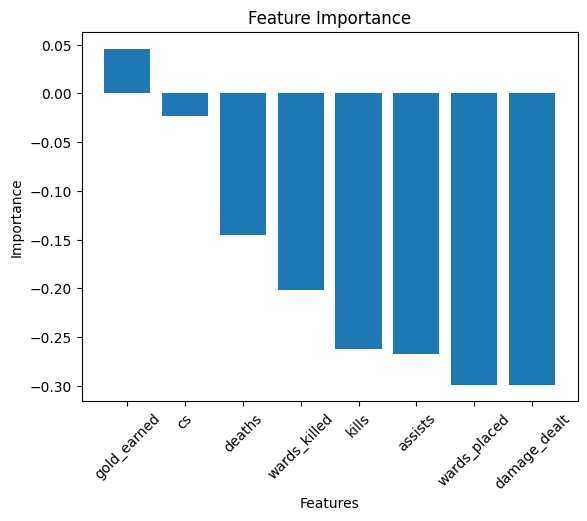

In [9]:
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_units=8):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_units,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.linear(x)).squeeze(1)
        return x

model = LogisticRegressionModel(X_train.shape[1])
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

weightarray=model.linear.weight.data.numpy().flatten()
features =X.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': weightarray})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)
#Plot feature importance plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()

#### Conclusion:  

Congratulations on completing the project! In this final project, you built a logistic regression model to predict the outcomes of League of Legends matches based on various in-game statistics. This comprehensive project involved several key steps, including data loading and preprocessing, model implementation, training, optimization, evaluation, visualization, model saving and loading, hyperparameter tuning, and feature importance analysis. This project provided hands-on experience with the complete workflow of developing a machine learning model for binary classification tasks using PyTorch.

© Copyright IBM Corporation. All rights reserved.
